# Clone code and download weights

In [1]:
# clone model
!git clone https://github.com/richarduuz/Research_Project

fatal: destination path 'Research_Project' already exists and is not an empty directory.


In [2]:
%cd /content/Research_Project/ModelC
!pip install -r requirements.txt

/content/Research_Project/ModelC


In [3]:
# download weights
%cd /content/Research_Project/ModelC/face_modules/
!gdown https://drive.google.com/uc?id=15nZSJ2bAT3m-iCBqP3N_9gld5_EGv4kp
%cd /content/Research_Project/ModelC/saved_models/
!gdown https://drive.google.com/uc?id=1iANX7oJoXCEECNzBEW1xOpac2tDOKeu9

/content/Research_Project/ModelC/face_modules
Downloading...
From (original): https://drive.google.com/uc?id=15nZSJ2bAT3m-iCBqP3N_9gld5_EGv4kp
From (redirected): https://drive.google.com/uc?id=15nZSJ2bAT3m-iCBqP3N_9gld5_EGv4kp&confirm=t&uuid=760c015e-c5e9-4789-b22c-ff986e087cc4
To: /content/Research_Project/ModelC/face_modules/model_ir_se50.pth
100% 175M/175M [00:01<00:00, 144MB/s]
/content/Research_Project/ModelC/saved_models
Downloading...
From (original): https://drive.google.com/uc?id=1iANX7oJoXCEECNzBEW1xOpac2tDOKeu9
From (redirected): https://drive.google.com/uc?id=1iANX7oJoXCEECNzBEW1xOpac2tDOKeu9&confirm=t&uuid=8c0017b4-7389-4989-9543-cc5b9c31e2b5
To: /content/Research_Project/ModelC/saved_models/G_latest.pth
100% 737M/737M [00:02<00:00, 267MB/s]


# Load Model

In [4]:
%cd /content/Research_Project/ModelC/

/content/Research_Project/ModelC


In [5]:
import sys
import torch
sys.path.append('./face_modules/')
import torchvision.transforms as transforms
import torch.nn.functional as F
from face_modules.model import Backbone, Arcface, MobileFaceNet, Am_softmax, l2_norm
from network.AEI_Net import *
from face_modules.mtcnn import *
import cv2
import PIL.Image as Image
import numpy as np
import configparser

/content/Research_Project/ModelC/./face_modules/mtcnn_pytorch/src/align_trans.py:289: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if align_type is 'cv2_affine':
/content/Research_Project/ModelC/./face_modules/mtcnn_pytorch/src/align_trans.py:292: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif align_type is 'affine':


In [6]:
detector = MTCNN()
device = torch.device('cuda')
G = AEI_Net(c_id=512)
G.eval()
G.load_state_dict(torch.load('./saved_models/G_latest.pth', map_location=torch.device('cpu')))
G = G.cuda()

arcface = Backbone(50, 0.6, 'ir_se').to(device)
arcface.eval()
arcface.load_state_dict(torch.load('./face_modules/model_ir_se50.pth', map_location=device), strict=False)

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

<ipython-input-6-cd82b8fb3154>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('./saved_models/G_latest.pth', map_location=torch.device('cpu'))

# Image Inference

## Upload source image

In [26]:
from google.colab import files
source_img = files.upload()
source_img_name = list(source_img.keys())[0]


Saving 000009.png to 000009.png


## Upload target image

In [27]:
from google.colab import files
target_img = files.upload()
target_img_name = list(target_img.keys())[0]

Saving 000009.png to 000009 (1).png


## Inference

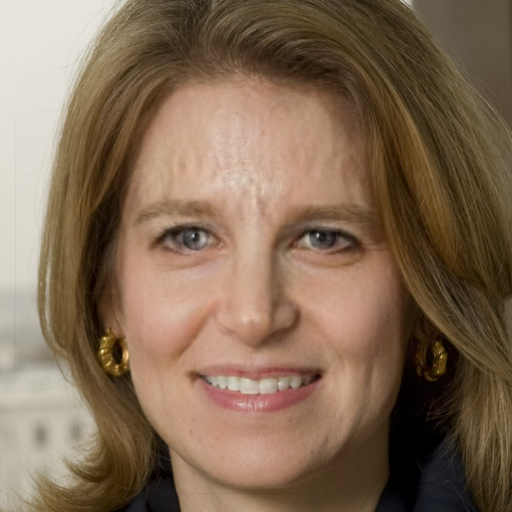

the result image has been saved


In [28]:
from google.colab.patches import cv2_imshow
Xs_raw = cv2.imread(source_img_name)
try:
    Xs = detector.align(Image.fromarray(Xs_raw[:, :, ::-1]), crop_size=(256, 256))
except Exception as e:
    print('the source image is wrong, please change the image')
Xs_raw = np.array(Xs)[:, :, ::-1]
Xs = test_transform(Xs)
Xs = Xs.unsqueeze(0).cuda()

with torch.no_grad():
    embeds = arcface(F.interpolate(Xs[:, :, 19:237, 19:237], (112, 112), mode='bilinear', align_corners=True))

Xt_raw = cv2.imread(target_img_name)
try:
    Xt, trans_inv = detector.align(Image.fromarray(Xt_raw[:, :, ::-1]), crop_size=(256, 256), return_trans_inv=True)
except Exception as e:
    print('the target image is wrong, please change the image')
Xt_raw = Xt_raw.astype(float)/255.0
Xt = test_transform(Xt)
Xt = Xt.unsqueeze(0).cuda()

mask = np.zeros([256, 256], dtype=float)
for i in range(256):
    for j in range(256):
        dist = np.sqrt((i-128)**2 + (j-128)**2)/128
        dist = np.minimum(dist, 1)
        mask[i, j] = 1-dist
mask = cv2.dilate(mask, None, iterations=20)

with torch.no_grad():
    Yt, _ = G(Xt, embeds)
    Yt = Yt.squeeze().detach().cpu().numpy().transpose([1, 2, 0])*0.5 + 0.5
    Yt = Yt[:, :, ::-1]
    Yt_trans_inv = cv2.warpAffine(Yt, trans_inv, (np.size(Xt_raw, 1), np.size(Xt_raw, 0)), borderValue=(0, 0, 0))
    mask_ = cv2.warpAffine(mask,trans_inv, (np.size(Xt_raw, 1), np.size(Xt_raw, 0)), borderValue=(0, 0, 0))
    mask_ = np.expand_dims(mask_, 2)
    Yt_trans_inv = mask_*Yt_trans_inv + (1-mask_)*Xt_raw
    cv2_imshow(Yt_trans_inv*255)
    cv2.imwrite('./result.jpg',Yt_trans_inv*255)
    print("the result image has been saved")
